In [60]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [80]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [175]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    # mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [197]:
Nx

121

In [176]:
# 셀 크기 설정
# cell_size = mp.Vector3(Sx*3, Sy)
cell_size = mp.Vector3(width_bot_ag*3, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [177]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [178]:
design_layer = np.loadtxt("SingleDipole_sum.txt")
design_variables.update_weights(design_layer)

<Axes: xlabel='X', ylabel='Y'>

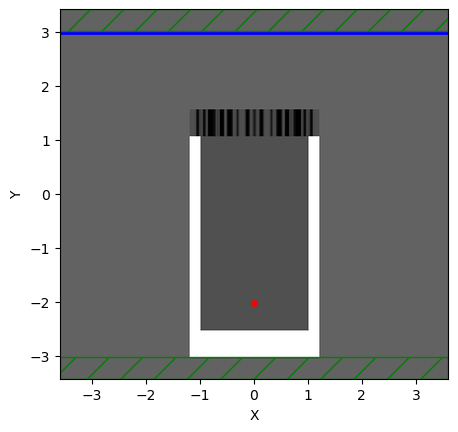

In [179]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        k_point=k0
    )
    for src in sources
]

monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(width_bot_ag*3, 0)

dft_monitor = sims[0].add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)


sims[0].plot2D()

<Axes: xlabel='X', ylabel='Y'>

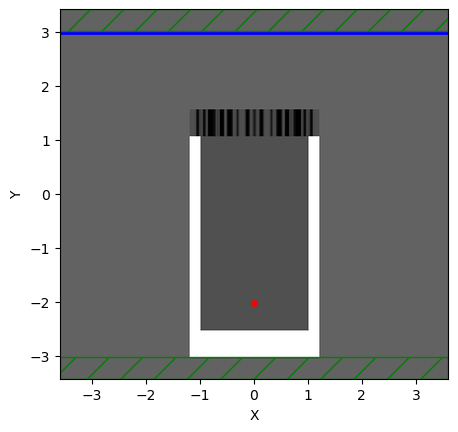

In [180]:
# sims[0].run(until_after_sources=mp.stop_when_fields_decayed(
#             10/df, mp.Ez, monitor_position_J, 1e-3
#         ))

# sims[0].run(until_after_sources = mp.stop_when_dft_decayed())
# sims[0].run(until_after_sources=mp.stop_when_dft_decayed())
sims[0].run(until=200)
Ez_dft =sims[0].get_dft_array(dft_monitor,mp.Ez,0)

sims[0].plot2D()

<Axes: xlabel='X', ylabel='Y'>

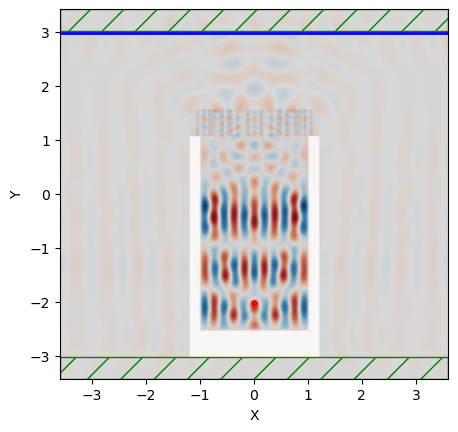

In [181]:
sims[0].plot2D(fields=mp.Ez)

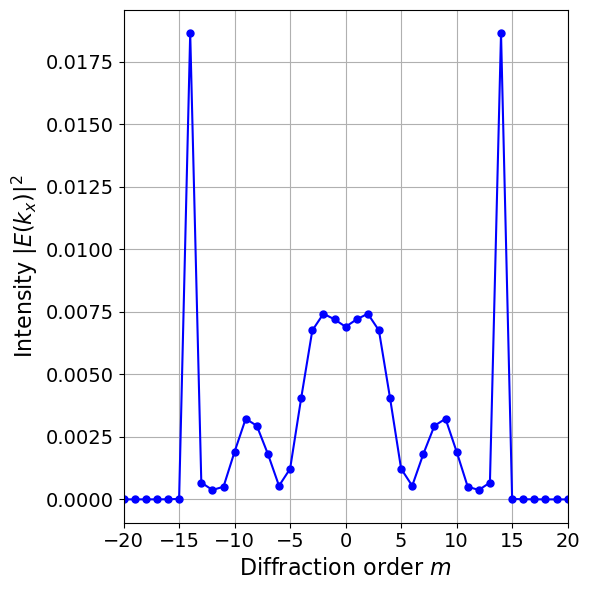

In [182]:
N        = len(Ez_dft)
dx       = 1.0 / resolution
E_k      = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))  
kx       = 2 * np.pi * kx_cycles                     

Delta_k = 2*np.pi/(N*dx)
p = kx/Delta_k

plt.figure(figsize=(6,6))
# plt.plot(p, np.abs(E_k)**2/max(np.abs(E_k)**2), 'ro-', markersize=5)
plt.plot(p, np.abs(E_k)**2, 'bo-', markersize=5)
plt.xlabel("Diffraction order $m$", fontsize=16)
plt.ylabel(r"Intensity $|E(k_x)|^2$",                   fontsize=16)
plt.xlim(-20, 20) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [171]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.25
flux_size = 0.5
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []
m = mp.Vector3(0, center_y_monitor_position-2/resolution)
# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, df, nfreq,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, df, nfreq,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, df, nfreq,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        # until_after_sources=mp.stop_when_fields_decayed(
        #     10/df, mp.Ez, m, 1e-3
        # )
        until_after_sources=mp.stop_when_dft_decayed()
        # until=300

    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.abs(x),
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.abs(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %")


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1


KeyboardInterrupt: 

In [212]:
k = [0.12218856, 0.14375953, 0.1651354 , 0.18582371, 0.2055273 ,
       0.22398752, 0.24085914, 0.25569432, 0.26797241, 0.27707695,
       0.28222936, 0.28248709, 0.27687249, 0.26458701, 0.24523616,
       0.21905784, 0.18717149, 0.15177802, 0.11615654, 0.08436444,
       0.06071819, 0.04923894, 0.05319264, 0.07473305, 0.11461667,
       0.17202575, 0.24459241, 0.32867199, 0.41980398, 0.5132314 ,
       0.60437481, 0.68922649, 0.76466676, 0.82868737, 0.88047935,
       0.92035126, 0.94949269, 0.96964797, 0.98278292, 0.99080793,
       0.99538578, 0.99782578, 0.99905462, 0.9996504 , 0.99992122,
       1.        , 0.99992122, 0.9996504 , 0.99905462, 0.99782578,
       0.99538578, 0.99080793, 0.98278292, 0.96964797, 0.94949269,
       0.92035126, 0.88047935, 0.82868737, 0.76466676, 0.68922649,
       0.60437481, 0.5132314 , 0.41980398, 0.32867199, 0.24459241,
       0.17202575, 0.11461667, 0.07473305, 0.05319264, 0.04923894,
       0.06071819, 0.08436444, 0.11615654, 0.15177802, 0.18717149,
       0.21905784, 0.24523616, 0.26458701, 0.27687249, 0.28248709,
       0.28222936, 0.27707695, 0.26797241, 0.25569432, 0.24085914,
       0.22398752, 0.2055273 , 0.18582371, 0.1651354 , 0.14375953,
       0.12218856]
k_angle = [-45., -44., -43., -42., -41., -40., -39., -38., -37., -36., -35.,
       -34., -33., -32., -31., -30., -29., -28., -27., -26., -25., -24.,
       -23., -22., -21., -20., -19., -18., -17., -16., -15., -14., -13.,
       -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,
        -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,
        21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
        43.,  44.,  45]

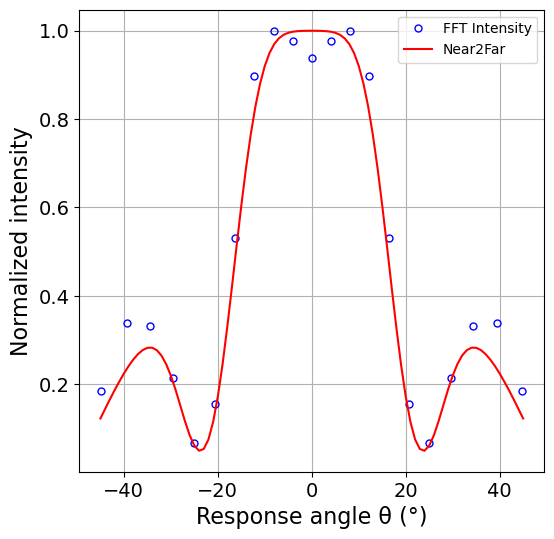

In [214]:
N         = len(Ez_dft)
dx        = 1.0 / resolution
E_k       = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx        = 2 * np.pi * kx_cycles

k0 = 2 * np.pi * fcen

ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))

P_fft = np.abs(E_k)**2 * (k0 * np.cos(np.radians(theta_deg)))

angle_min = -45
angle_max =  45
mask      = (theta_deg >= angle_min) & (theta_deg <= angle_max)

theta_sel  = theta_deg[mask]      
P_fft_sel  = P_fft[mask]
P_fft_sel /= np.max(P_fft_sel)    

# plt.figure(figsize=(6,6))
# plt.plot(theta_sel, P_fft_sel, 'bo-', markersize=5,)
# # plt.plot(k_angle, k, 'r-', markersize=5, label = "Near2Far")

# plt.xlabel("Response angle θ (°)", fontsize=16)
# plt.ylabel("Normalized intensity", fontsize=16)
# plt.xlim(angle_min, angle_max)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.grid(True)
# plt.legend()
# plt.show()
plt.figure(figsize=(6,6))
plt.plot(
    theta_sel,
    P_fft_sel,
    # linestyle='-',
    linestyle='none',
    marker='o',
    markersize=5,
    color='blue',            # 선 색 지정
    markeredgecolor='blue',  # 마커 테두리 색
    markerfacecolor='none',  # 마커 내부 빈칸
    label='FFT Intensity'
)
plt.plot(k_angle, k, 'r-', markersize=5, label = "Near2Far")
plt.xlabel("Response angle θ (°)", fontsize=16)
plt.ylabel("Normalized intensity", fontsize=16)
# plt.xlim(angle_min, angle_max)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


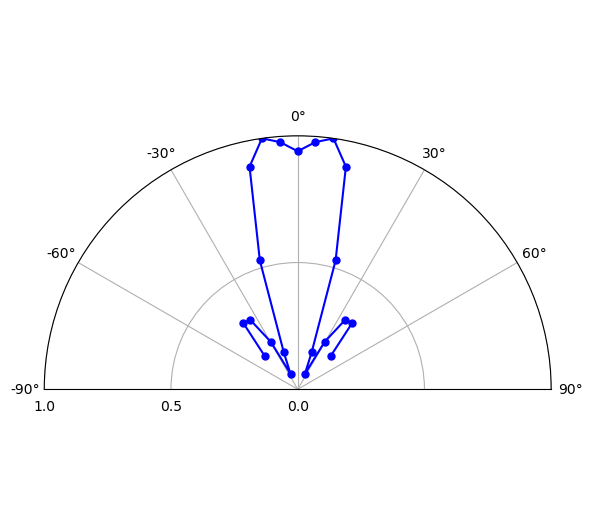

In [215]:
import numpy as np
import matplotlib.pyplot as plt

# — 기존 데이터 계산 —
N         = len(Ez_dft)
dx        = 1.0 / resolution
E_k       = np.fft.fftshift(np.fft.fft(Ez_dft)) / N
kx_cycles = np.fft.fftshift(np.fft.fftfreq(N, d=dx))
kx        = 2 * np.pi * kx_cycles

k0 = 2 * np.pi * fcen

ratio      = kx / k0
ratio_clip = np.clip(ratio, -1.0, 1.0)
theta_deg  = np.degrees(np.arcsin(ratio_clip))

P_fft = np.abs(E_k)**2 * (k0 * np.cos(np.radians(theta_deg)))

# — 원하는 각도 범위만 선택 —
angle_min = -45
angle_max =  45
mask      = (theta_deg >= angle_min) & (theta_deg <= angle_max)

theta_sel  = theta_deg[mask]
P_fft_sel  = P_fft[mask]
P_fft_sel /= np.max(P_fft_sel)

# 라디안 변환
theta_rad = np.radians(theta_sel)

# — half-polar plot —
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='polar')

# θ=0을 위쪽(North)으로, 시계방향으로 각도 증가
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# –45°…+45°만 표시
ax.set_thetamin(-90)
ax.set_thetamax(90)

# 데이터 플롯
ax.plot(theta_rad, P_fft_sel, 'bo-', markersize=5)

# r축(반경) 설정
ax.set_rlim(0, 1)
ax.set_rticks([0, 0.5, 1.0])

# 타이틀 및 범례
# ax.legend(loc='lower right')

ax.grid(True)
plt.tight_layout()
plt.show()
